In [1]:
import pandas as pd
import numpy as np

def make_test_dataframe(n: int = 48, freq: str = "h", seed: int = 42, start=pd.Timestamp("2025-01-01 00:00")) -> pd.DataFrame:
    """
    Create a synthetic sensor dataset for testing HydroData and DataProcessor methods.

    Parameters
    ----------
    n : int, default 48
        Number of time points.
    freq : str, default 'H'
        Frequency string for the DatetimeIndex (e.g., 'H', '15min').
    seed : int, default 42
        Random seed for reproducibility.

    Returns
    -------
    pd.DataFrame
        A test DataFrame with columns ["flow", "level", "rain"] and a DatetimeIndex.
        Includes some NaNs, a duplicate timestamp, and an intentional gap.
    """
    rng = np.random.default_rng(seed)
    start = start
    idx = pd.date_range(start=start, periods=n, freq=freq)

    # Add a duplicate timestamp
    idx = idx.insert(10, idx[10])

    # Drop one index to create a gap
    idx = idx.delete(20)

    df = pd.DataFrame(
        {
            "flow": rng.normal(loc=100, scale=10, size=len(idx)),
            "level": rng.normal(loc=5, scale=0.5, size=len(idx)),
            "rain": rng.poisson(lam=0.2, size=len(idx)).astype(float),
        },
        index=idx,
    )

    # Introduce some NaNs
    df.iloc[5, 0] = np.nan  # missing flow
    df.iloc[15, 1] = np.nan  # missing level
    df.iloc[25, 2] = np.nan  # missing rain

    df.index.name = "Datetime"
    return df

## processing

In [2]:
df = make_test_dataframe(n=1000)
df.head()

,flow,level,rain
Datetime,,,
2025-01-01 00:00:00,103.047171,4.970359,0.0
2025-01-01 01:00:00,89.600159,4.635357,0.0
2025-01-01 02:00:00,107.504512,4.792763,0.0
2025-01-01 03:00:00,109.405647,5.316955,0.0
2025-01-01 04:00:00,80.489648,5.001497,0.0


In [1]:
from data_processor import DataProcessor

In [4]:
dp = DataProcessor(df)

[2025-10-17 12:14:13,627] INFO: Logger initialized for processor


In [9]:
dp.build_default_pipeline(columns=['flow'], small_gap_limit=2)

OnlineSensorBased object reset to original state.


In [6]:
print(dp.summary())

     enabled    kind             key                      method column  \
idx                                                                       
0       True  filter         tag_nan                     tag_nan   flow   
1       True  filter  moving_average       moving_average_filter   flow   
2       True  filter          zscore               zscore_filter   flow   
3       True  filter             iqr                  iqr_filter   flow   
4       True    fill   interpolation  fill_missing_interpolation   flow   

                                                params  
idx                                                     
0                     {'arange': None, 'clear': False}  
1    {'window': 7, 'cutoff_frac': 0.25, 'arange': N...  
2    {'k': 2.71, 'arange': None, 'final': False, 'i...  
3    {'k': 1.5, 'arange': None, 'final': False, 'in...  
4    {'range_': 2, 'arange': None, 'method': 'time'...  


/home/saba/Desktop/wwdata_refactor/Class_OnlineSensorBased.py:1352: UserWarning: When using filling functions, start with small gaps and progressively move to larger gaps. This improves algorithm reliability. This notice is shown only once.
  self._filling_warning()
[2025-10-17 12:17:02,835] INFO: Data processing run is finished!


1 values detected and tagged as filtered by function NaN tagging
7 values detected and tagged as filtered by function moving average filter (kind=mean)
6 values detected and tagged as filtered by function z-score filter (standard)
10 values detected and tagged as filtered by function IQR filter (k=1.5)


[(0, 'tag_nan', {'arange': None, 'clear': False}, None),
 (1,
  'moving_average_filter',
  {'window': 7,
   'cutoff_frac': 0.25,
   'arange': None,
   'clear': False,
   'final': False,
   'inplace': False,
   'plot': False},
  None),
 (2,
  'zscore_filter',
  {'k': 2.71, 'arange': None, 'final': False, 'inplace': False, 'plot': False},
  None),
 (3,
  'iqr_filter',
  {'k': 1.5, 'arange': None, 'final': False, 'inplace': False, 'plot': False},
  None),
 (4,
  'fill_missing_interpolation',
  {'range_': 2,
   'arange': None,
   'method': 'time',
   'clear': False,
   'plot': True},
  None)]

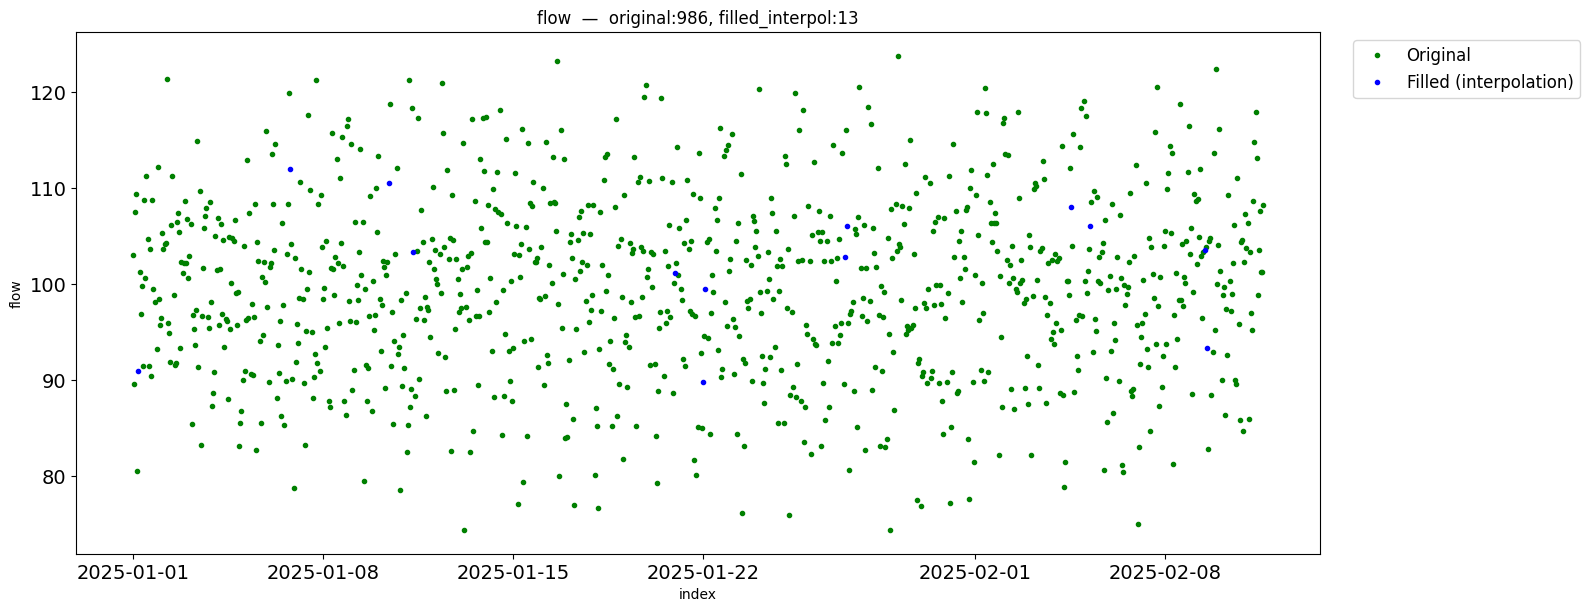

In [10]:
dp.run()

In [ ]:

grid = {"k": [1.0, 1.5, 2.0, 2.5]}
best = dp.brute_force_filter_params("flow", key="iqr", param_grid=grid, base_kwargs={"arange": None})
print(best)

42 values detected and tagged as filtered by function IQR filter (k=1.0)
0 values detected and tagged as filtered by function IQR filter (k=1.5)
0 values detected and tagged as filtered by function IQR filter (k=2.0)
0 values detected and tagged as filtered by function IQR filter (k=2.5)
{'best_params': {'k': 1.0}, 'score': 1.0}


In [14]:
dp.clear_pipeline()

                           flow     level  rain
Datetime                                       
2025-01-01 00:00:00  103.047171  4.970359   0.0
2025-01-01 01:00:00   89.600159  4.635357   0.0
2025-01-01 02:00:00  107.504512  4.792763   0.0
2025-01-01 03:00:00  109.405647  5.316955   0.0
2025-01-01 04:00:00   80.489648  5.001497   0.0
...                         ...       ...   ...
2025-02-11 11:00:00  103.527202  5.196005   0.0
2025-02-11 12:00:00  107.668229  5.151919   1.0
2025-02-11 13:00:00  101.211779  4.954230   1.0
2025-02-11 14:00:00  101.307642  4.734589   0.0
2025-02-11 15:00:00  108.237531  6.107076   0.0

[999 rows x 3 columns]
OnlineSensorBased object reset to original state.


In [15]:

variable = 'flow'
dp.add_step('filter', 'tag_nan', variable, arange=None)
dp.add_step('filter', 'moving_average', variable, window=7, cutoff_frac=0.25)
dp.add_step('filter', 'iqr', variable, k=1.5)
dp.add_step('fill', 'interpolation', variable, range_=5, plot=True)
dp.add_step('fill', 'kalman', variable, plot=True)

1 values detected and tagged as filtered by function NaN tagging
7 values detected and tagged as filtered by function moving average filter (kind=mean)
10 values detected and tagged as filtered by function IQR filter (k=1.5)


/home/saba/Desktop/wwdata_refactor/Class_OnlineSensorBased.py:1352: UserWarning: When using filling functions, start with small gaps and progressively move to larger gaps. This improves algorithm reliability. This notice is shown only once.
  self._filling_warning()


[(0, 'tag_nan', {'arange': None}, None),
 (1, 'moving_average_filter', {'window': 7, 'cutoff_frac': 0.25}, None),
 (2, 'iqr_filter', {'k': 1.5}, None),
 (3, 'fill_missing_interpolation', {'range_': 5, 'plot': True}, None),
 (4, 'fill_missing_kalman', {'plot': True}, None)]

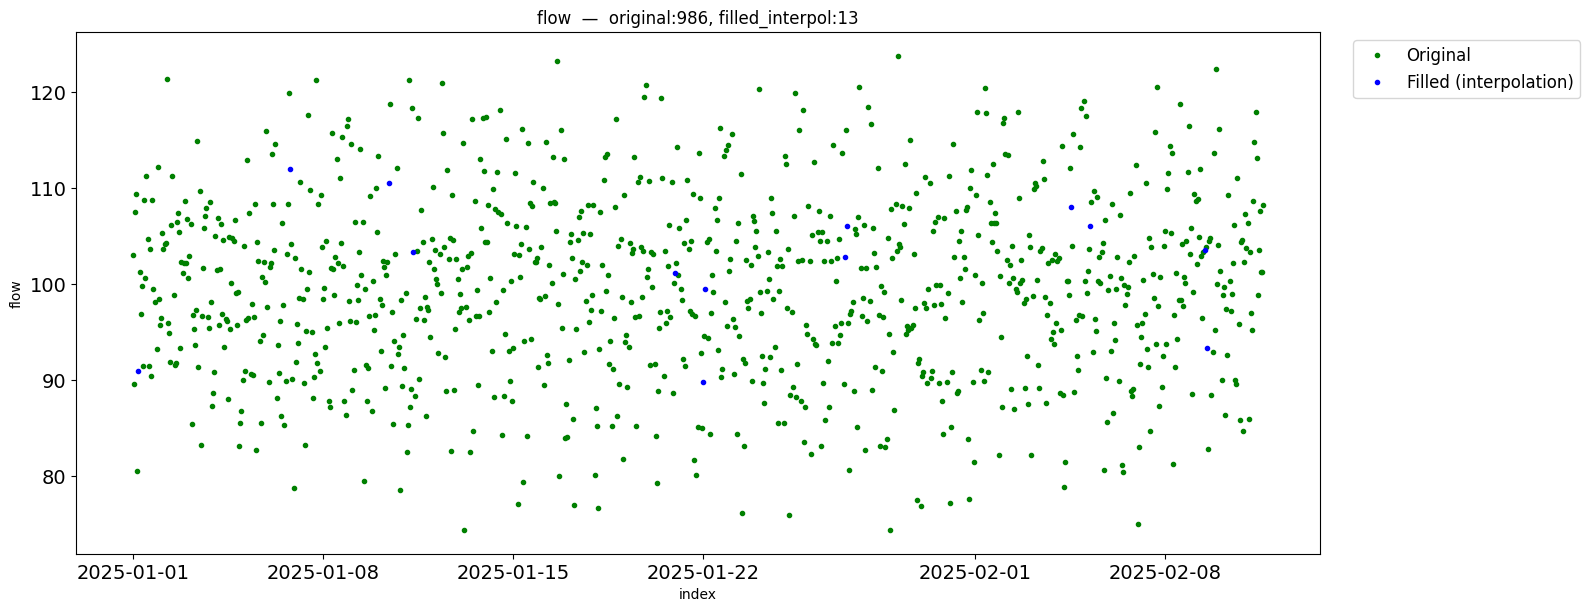

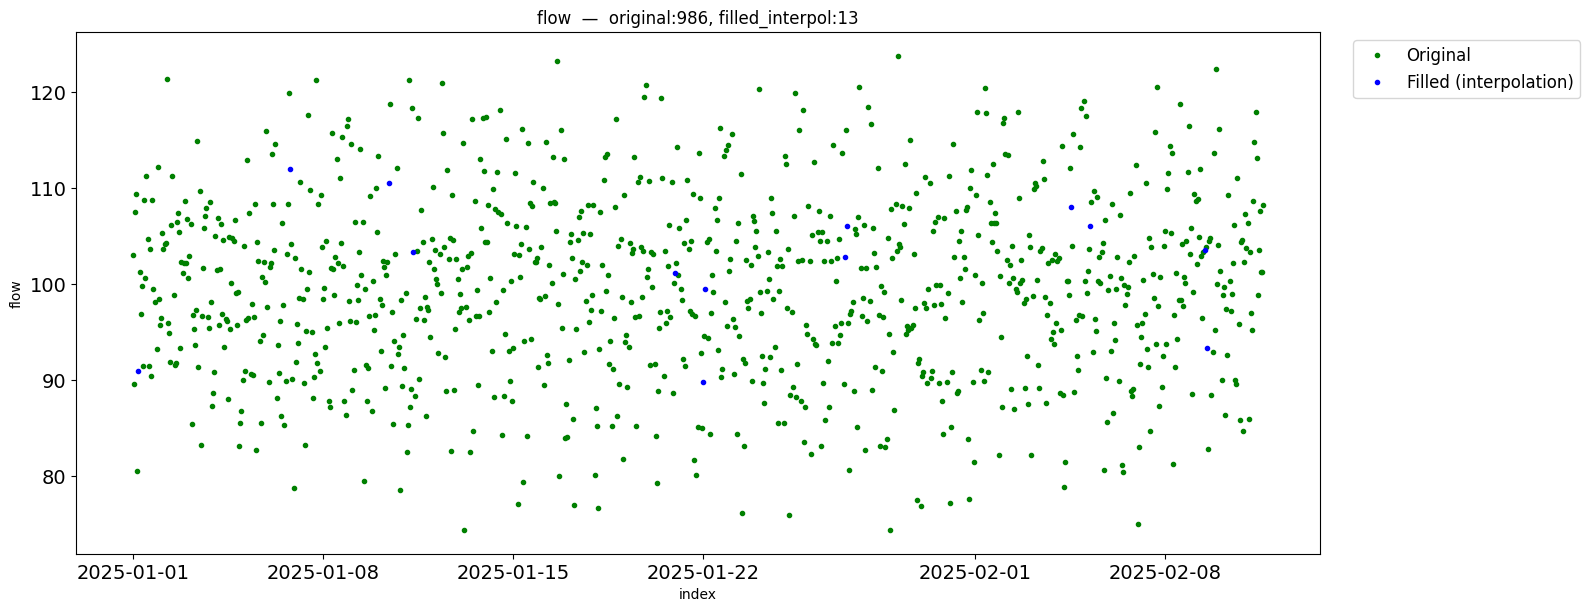

In [16]:
dp.run()

In [ ]:
fill_grid = {"range_": [3, 5, 7, 9]}
start = dp.osb.data.index.min()
end = dp.osb.data.index.max()


best_fill = dp.brute_force_fill_params_with_reliability(
    column="flow",
    key="interpolation",
    param_grid=fill_grid,
    test_data_range=(start, end),
    nr_iterations=2,
    nr_small_gaps=2, max_size_small_gaps=5
)
print(best_fill)

{'best_params': {}, 'score': None}


/home/saba/Desktop/wwdata_refactor/Class_OnlineSensorBased.py:1295: UserWarning: When using filling functions, start with small gaps and progressively move to larger gaps. This improves algorithm reliability. This notice is shown only once.
  self._filling_warning()
/home/saba/Desktop/wwdata_refactor/Class_OnlineSensorBased.py:1183: UserWarning: Data points obtained during rain/high events will be replaced. Ensure the chosen method is appropriate for gaps during rain events.
  self._rain_warning()
/home/saba/Desktop/wwdata_refactor/Class_OnlineSensorBased.py:1295: UserWarning: When using filling functions, start with small gaps and progressively move to larger gaps. This improves algorithm reliability. This notice is shown only once.
  self._filling_warning()
/home/saba/Desktop/wwdata_refactor/Class_OnlineSensorBased.py:1183: UserWarning: Data points obtained during rain/high events will be replaced. Ensure the chosen method is appropriate for gaps during rain events.
  self._rain_warn

In [9]:
dp.export_data('/home/saba/Desktop/')

✅ Export complete: /home/saba/Desktop/processed_data_20251017_111604.zip


'/home/saba/Desktop/processed_data_20251017_111604.zip'